In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import warnings

In [427]:
output_dir = "../00_data/03_analysis_data"
df = pd.read_csv(f"../00_data/03_analysis_data/sasami_2222.csv")

In [408]:
# Ensure sorting
df = df.sort_values(['factor', 'cbsacode', 'Year'])

# Create a results list to collect ADF p-values
results_list = []

# Step 1: detrend per factor-location and track ADF p-values
def hybrid_detrend(group):
    y = group['SSAMI'].values
    x = np.arange(len(y))
    result = {'factor': group['factor'].iloc[0],
              'cbsacode': group['cbsacode'].iloc[0],
              'adf_p_original': np.nan,
              'adf_p_final': np.nan}
    try:
        # ADF p-value on original series
        result['adf_p_original'] = adfuller(y)[1]

        # Try Auto ARIMA
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = pm.auto_arima(y, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        residuals = pd.Series(model.resid(), index=group.index)
        adf_p = adfuller(residuals.dropna())[1]

        if adf_p >= 0.05:
            # Try linear detrend
            coeffs = np.polyfit(x, y, 1)
            trend = np.polyval(coeffs, x)
            residuals = pd.Series(y - trend, index=group.index)
            adf_p = adfuller(residuals.dropna())[1]

        # Fill the detrended column, with fallback to original if needed
        group = group.copy()
        group['detrended'] = y  # default to original

        if len(residuals.dropna()) >= 1:
            group.loc[residuals.index, 'detrended'] = residuals.values

        # Save final p-value
        result['adf_p_final'] = adf_p

    except Exception as e:
        print(f"Detrending failed for factor {group['factor'].iloc[0]}, cbsacode {group['cbsacode'].iloc[0]}: {e}")
        group['detrended'] = y  # fallback to original

    # Append result to list
    results_list.append(result)
    return group

# Apply function
df = df.groupby(['factor', 'cbsacode'], group_keys=False).apply(hybrid_detrend)

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)

/var/folders/xn/k3tchqyx5bn081b3tlx0k4940000gn/T/ipykernel_8858/2951106504.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['factor', 'cbsacode'], group_keys=False).apply(hybrid_detrend)


In [424]:
# Ensure sorting
df = df.sort_values(['factor', 'cbsacode', 'Year'])

# Create a results list to collect ADF p-values
results_list = []

# Step 1: detrend per factor-location using only ARIMA
def arima_detrend(group):
    y = group['SSAMI'].values
    result = {'factor': group['factor'].iloc[0],
              'cbsacode': group['cbsacode'].iloc[0],
              'adf_p_original': np.nan,
              'adf_p_final': np.nan}
    try:
        # ADF p-value on original series
        result['adf_p_original'] = adfuller(y)[1]

        # Fit Auto ARIMA
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = pm.auto_arima(y, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        residuals = pd.Series(model.resid(), index=group.index)
        adf_p = adfuller(residuals.dropna())[1]

        # Fill detrended column with ARIMA residuals
        group = group.copy()
        group['detrended'] = y  # fallback to original
        if len(residuals.dropna()) >= 1:
            group.loc[residuals.index, 'detrended'] = residuals.values

        # Save final p-value
        result['adf_p_final'] = adf_p

    except Exception as e:
        print(f"ARIMA detrending failed for factor {group['factor'].iloc[0]}, cbsacode {group['cbsacode'].iloc[0]}: {e}")
        group['detrended'] = y  # fallback to original

    # Append result to list
    results_list.append(result)
    return group

# Apply function
df = df.groupby(['factor', 'cbsacode'], group_keys=False).apply(arima_detrend)

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)

/var/folders/xn/k3tchqyx5bn081b3tlx0k4940000gn/T/ipykernel_8858/3530615802.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['factor', 'cbsacode'], group_keys=False).apply(arima_detrend)


In [425]:
df = df.merge(results_df)
df.to_csv(f'{output_dir}/detrend_result_0508_arima.csv',index=False)

In [419]:
my_factors = ['Depression',

    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'Unhealthy Lifestyle',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
     'Mental Health Providers', 
     'Physical Inactivity',

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'GDP', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'Noise', 

    # social association
    # 'children_single_parent',

    # enviroment
    # 'driving_alone_to_work', 
    # 'Driving Alone to Work',
    'Park Area',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    
]

In [420]:
df.loc[df['factor'] == 'Park_Area_Acres', 'factor'] = 'Park Area'
df.loc[df['factor'] == 'noise90n', 'factor'] = 'Noise'
df.loc[df['factor'] == 'no_time_activity', 'factor'] = 'Physical Inactivity'
df.loc[df['factor'] == 'smo_obe_dia', 'factor'] = 'Unhealthy Lifestyle'
df.loc[df['factor'] == 'depressed', 'factor'] = 'Depression'
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'Mental Health Providers'
df.loc[df['factor'] == 'driving_alone_to_work', 'factor'] = 'Driving Alone to Work'

In [421]:
df = df[df['factor'].isin(my_factors)]

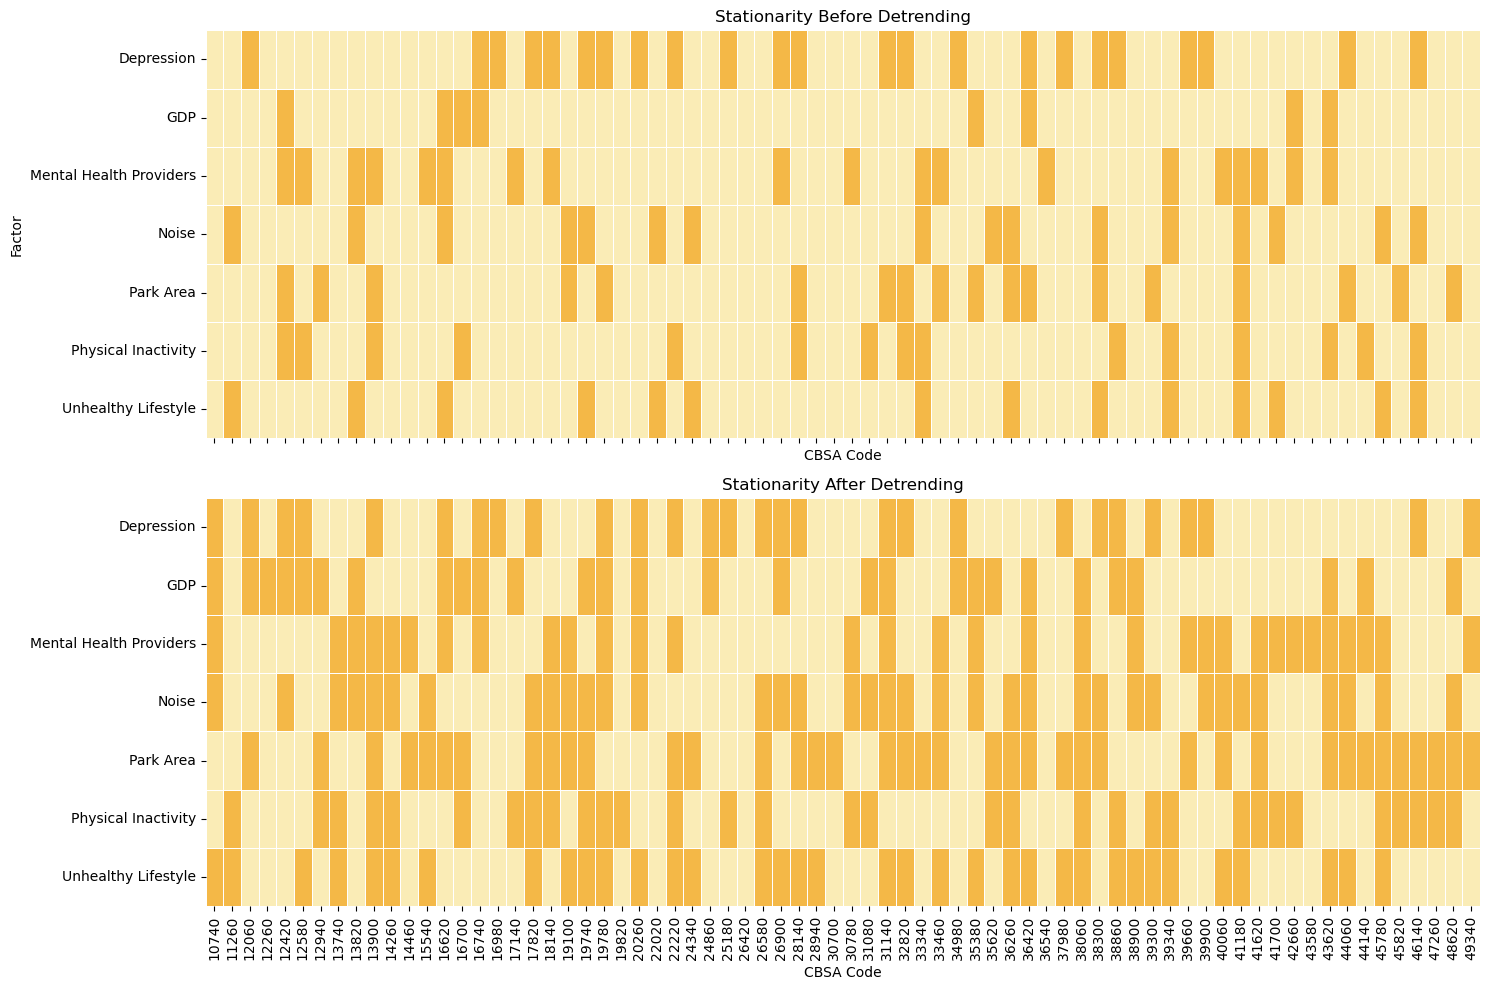

In [422]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example: df_out has ['factor', 'cbsacode', 'adf_p_original', 'adf_p_final']
# You need to prepare this DataFrame first

# Define threshold
threshold = 0.05

# Compute binary matrices
df['stationary_orig'] = (df['adf_p_original'] < threshold).astype(int)
df['stationary_final'] = (df['adf_p_final'] < threshold).astype(int)

# Pivot tables
heatmap_orig = df.pivot_table(index='factor', columns='cbsacode', values='stationary_orig', aggfunc='max')
heatmap_final = df.pivot_table(index='factor', columns='cbsacode', values='stationary_final', aggfunc='max')

# Plot side by side
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.heatmap(
    heatmap_orig,
    ax=axes[0],
    cmap=sns.color_palette(['#FAECB6', '#F4B847']),
    cbar=False,
    linewidths=0.5,
    linecolor='white'
)
axes[0].set_title('Stationarity Before Detrending')
axes[0].set_xlabel('CBSA Code')
axes[0].set_ylabel('Factor')

sns.heatmap(
    heatmap_final,
    ax=axes[1],
    cmap=sns.color_palette(['#FAECB6', '#F4B847']),
    cbar=False,
    cbar_kws={'label': 'Stationary (1) vs Non-Stationary (0)'},
    linewidths=0.5,
    linecolor='white'
)
axes[1].set_title('Stationarity After Detrending')
axes[1].set_xlabel('CBSA Code')
axes[1].set_ylabel('')

# Tight layout
plt.tight_layout()
plt.show()

In [405]:
my_factors = ['Depression',

    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'Unhealthy Lifestyle',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
     'Mental Health Providers', 
     'Physical Inactivity',

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'GDP', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'Noise', 

    # social association
    # 'children_single_parent',

    # enviroment
    # 'driving_alone_to_work', 
    # 'Driving Alone to Work',
    'Park Area',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    
    
]

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume df has: ['factor', 'cbsacode', 'Year', 'SSAMI', 'detrended', 'adf_p']

# Sort factors and CBSAs
factors = my_factors       # 7 factors → columns
locations = sorted(df['cbsacode'].unique())    # 72 CBSAs → rows

# Split CBSA list into 12 chunks (6 per page)
chunks = [locations[i:i + 6] for i in range(0, len(locations),6)]

# Loop over chunks
for chunk_idx, chunk in enumerate(chunks):
    nrows = len(chunk)
    ncols = len(factors)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 1), sharex=False, sharey=False)
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for i, loc in enumerate(chunk):
        for j, factor in enumerate(factors):
            ax = axes[i, j]
            subset = df[(df['factor'] == factor) & (df['cbsacode'] == loc)]
            if subset.empty:
                ax.axis('off')
                continue
            
            x = np.arange(len(subset))
            y = subset['SSAMI'].values
            coeffs = np.polyfit(x, y, 1)
            trend = np.polyval(coeffs, x)
            
            ax.plot(subset['Year'], y, linewidth=1)
            ax.plot(subset['Year'], subset['detrended'], linewidth=1)
            ax.plot(subset['Year'], trend, linestyle='--', color='black', linewidth=1)
            
            if i == 0:
                ax.set_title(factor, fontsize=6)
            if j == 0:
                ax.set_ylabel(loc, fontsize=5)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add red border if non-stationary (p ≥ 0.05)
            adf_p = subset['adf_p_final'].iloc[0]
            if adf_p >= 0.05:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(1.5)
    
    # Add legend once on top
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=6)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Save each chunk
    plt.savefig(f'panel_chunk_{chunk_idx + 1}_redbox.png', dpi=600, bbox_inches='tight')
    plt.close()